In [ ]:
import torch 
import numpy as np
import math
import matplotlib.pyplot as plt

In [ ]:
def fastfindNNPre(x, m):
    n = x.shape[0]
    
    x_padded = torch.cat((x, torch.zeros(n)))

    X = torch.fft.fft(x_padded)

    cum_sumx = torch.cumsum(x_padded, dim=0)
    cum_sumx2 = torch.cumsum(x_padded**2, dim=0)

    
    sumx2 = cum_sumx2[m-1:n] - torch.cat((torch.zeros(1, dtype=cum_sumx2.dtype), cum_sumx2[:n-m]), dim=0)
    sumx = cum_sumx[m-1:n] - torch.cat((torch.zeros(1, dtype=cum_sumx2.dtype), cum_sumx[:n-m]), dim=0)
    meanx = sumx / m
    sigmax2 = (sumx2 / m) - (meanx**2)
    sigmax = torch.sqrt(sigmax2)

    return X, n, sumx2, sumx, meanx, sigmax2, sigmax

In [ ]:
def fastfindNN(X, y, n, m, sumx2, sumx, meanx, sigmax2, sigmax):
    dropval= y[0]
    y = torch.flip(y,dims=[0,])
    y_padded = torch.cat((y, torch.zeros(n*2-m+1)))

    #The main trick of getting dot products in O(n log n) time
    Y = torch.fft.fft(y_padded)
    Z = X*Y
    z = torch.fft.ifft(Z)

    #compute y stats -- O(n)
    sumy = torch.sum(y_padded)
    sumy2 = sum(y_padded**2)
    meany=  sumy/m
    sigmay2 = sumy2/m-meany**2
    sigmay = math.sqrt(sigmay2)

    dist = 2*(m-(z[m-1:n]-m*meanx*meany)/(sigmax*sigmay))
    dist = torch.sqrt(dist)
    lastz= torch.real(z[m-1:n])

    return dist ,lastz ,dropval ,sumy ,sumy2

In [548]:
def TSC1_demo(A, subsequenceLength, anchor = 0):

    exclusionZone = round(subsequenceLength/4)

    A_float = A.float()

    if subsequenceLength > len(A/4):
        raise TypeError("Error: Time series is too short relative to desired subsequence length")
    
    if subsequenceLength < 4: 
        raise TypeError('Error: Subsequence length must be at least 4')

    if A.dim() == 2 and A.shape[0] == 1:
        A = A.T  

    # initialization
    MatrixProfileLength = A.shape[0] - subsequenceLength + 1
    MPLeft = torch.ones(MatrixProfileLength) * torch.finfo(torch.float32).max
    MPindexLeft = torch.zeros(MatrixProfileLength)
    MPRight = torch.ones(MatrixProfileLength) * torch.finfo(torch.float32).max
    MPindexRight = torch.zeros(MatrixProfileLength)
    X, n, sumx2, sumx, meanx, sigmax2, sigmax = fastfindNNPre(A, subsequenceLength)

    pickedIdx = A[:MatrixProfileLength]; 
    dropval= 0
    distanceProfile = torch.zeros(MatrixProfileLength,1)
    lastz = torch.zeros(MatrixProfileLength,1)
    updatePosRight= torch.zeros(MatrixProfileLength, dtype=torch.bool)
    updatePosLeft= torch.zeros(MatrixProfileLength, dtype=torch.bool)

    for i in range(pickedIdx.shape[0]-1):
        idx = pickedIdx[i]
        subsequence = A[idx:idx+subsequenceLength-1]

        if i == 0:
            distanceProfile, lastz ,dropval ,lastsumy, lastsumy2 = fastfindNN(X, subsequence, n, subsequenceLength,sumx2, sumx, meanx, sigmax2, sigmax)
            distanceProfile = torch.abs(distanceProfile)
            firstz=lastz
        else:
            lastsumy = lastsumy-dropval+subsequence[-1]
            lastsumy2 = lastsumy2 - dropval**2 + subsequence[-1]**2
            meany= lastsumy/subsequenceLength
            sigmay2 = lastsumy2/subsequenceLength-meany**2
            sigmay = math.sqrt(sigmay2)
            lastz[1:n-subsequenceLength]=lastz[0:n-subsequenceLength-1]-A[0:n-subsequenceLength-1]*dropval+A[subsequenceLength+1:n]*subsequence[subsequenceLength-2]
            lastz[0]=firstz[i]
            distanceProfile = torch.sqrt(2*(subsequenceLength-(lastz-subsequenceLength*meanx*meany)/(sigmax*sigmay)))
            dropval=subsequence[1]

        # apply exclusion zone
        exclusionZoneStart = max(1, idx-exclusionZone)
        exclusionZoneEnd = min(MatrixProfileLength, idx+exclusionZone)
        distanceProfile[exclusionZoneStart:exclusionZoneEnd] = torch.finfo(torch.float32).max
        
        # figure out and store the nearest neighbor
        updatePosLeft[1:(idx-1)] = False
        updatePosLeft[idx:MatrixProfileLength] = distanceProfile[idx:MatrixProfileLength] < MPLeft[idx:MatrixProfileLength]
        MPLeft[updatePosLeft] = distanceProfile[updatePosLeft]
        MPindexLeft[updatePosLeft] = idx
        
        updatePosRight[(idx+1):MatrixProfileLength] = False
        updatePosRight[1:idx] = distanceProfile[1:idx] < MPRight[1:idx]
        MPRight[updatePosRight] = distanceProfile[updatePosRight]
        MPindexRight[updatePosRight] = idx

        if i%1000 == 0:
            None
        

    ChainPos = torch.zeros(MatrixProfileLength, dtype=torch.bool)
    ChainLength = torch.zeros(MatrixProfileLength,1)

    for i in range(MatrixProfileLength-1):
        if ChainPos[i] == False:
            cur = i
            count=1
            while MPindexRight[cur] > 0 and MPindexLeft[MPindexRight[cur]]==cur:
                ChainPos[int(cur)]= True
                cur=MPindexRight[cur]
                count += 1

            ChainLength[i] = count
    
    if anchor == 0:
        ChainStart, _ = torch.max(ChainLength, dim=0)
        ChainStart = ChainStart + 1    
    else:
        ChainStart = anchor

    count=ChainLength[int(ChainStart)]

    count = int(count)
        
    numpy_array = A.numpy()

    plt.figure()
    plt.plot(numpy_array) 
    
    cur=int(ChainStart)
    next=int(ChainStart)
    cur_max = 0
    cur_min = 0


    for i in range(count):
        next = MPindexRight[cur]
        cur_pattern = (A_float[cur:cur+subsequenceLength] - torch.mean(A_float[cur:cur+subsequenceLength])) 
        cur_pattern /= torch.std(A_float[cur:cur+subsequenceLength])
        
        cur_max = max(torch.max(cur_pattern), cur_max)
        cur_min = min(torch.min(cur_pattern), cur_min)

        if i >= 1:
            diff = cur_pattern - last_pattern
            cur_max_diff = torch.max(torch.max(diff), cur_max_diff)
            cur_min_diff = torch.min(torch.min(diff), cur_min_diff)

        last_pattern = cur_pattern
        cur = next

    cur = ChainStart
    i = 1
    last_pattern = None
    plt.figure()

    while i <= count:

        cur = int(cur)
    
        plt.subplot(math.ceil(count/3), 3, i)
        plt.plot(range(cur, cur+subsequenceLength), cur_pattern.numpy())
        plt.xlim(cur, cur+subsequenceLength-1)
        plt.ylim(cur_min.item(), cur_max.item())

        if i > 1:
            plt.plot(range(cur, cur + subsequenceLength), (cur_pattern - last_pattern).numpy(), 'r')

        plt.figure()
        plt.plot(range(cur, cur+subsequenceLength), A[cur:cur+subsequenceLength].numpy(), 'r')

        cur = MPindexRight[cur]
        last_pattern = cur_pattern
        i += 1 
           



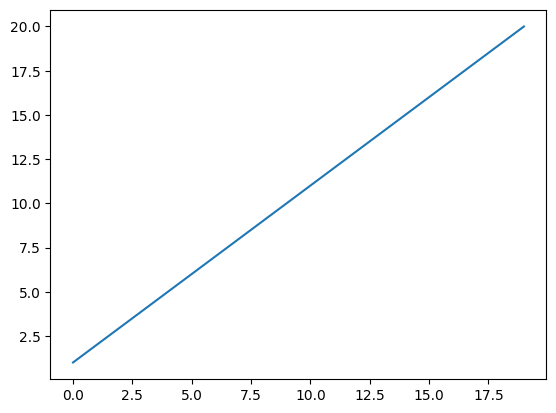

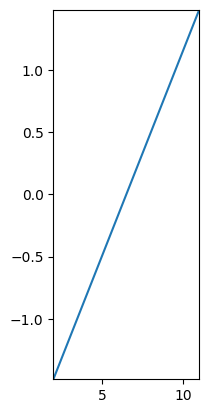

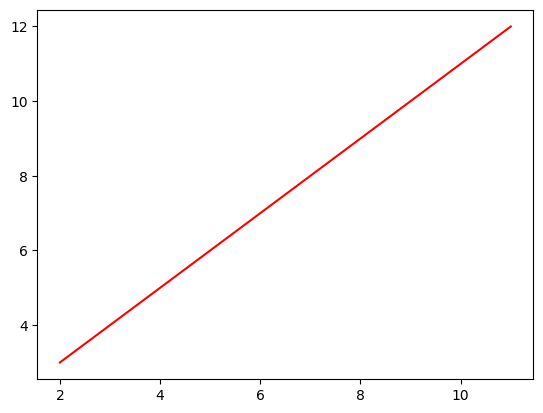

In [549]:
data = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20]
x_data = torch.tensor(data)
TSC1_demo(x_data, 10)